# Introduction & Background

https://mkhosla-ucsd.github.io/cogs138/final-group-project/part-one

https://docs.google.com/document/d/1LfJ4vg_xP5eI0bps2WufYN-6KIQQdCxOKaiI-GMB69E/edit#heading=h.33dozdup4vlm

### Overview

 ❏    Write a clear summary of what you did

 ❏    Limit overview to 3-4 sentences


### Research Question
 ❏    Include your _specific_ data science question

 ❏    Make sure what you’re measuring (variables) to answer your question is clear


### Background & Prior Work
 ❏    Include explanation of what work has been done previously

 ❏    Include citations or links to previous work

 ❏    Include an explanation of dataset(s) used (_i.e._, how the data was collected, features/variables included, number of observations, information in dataset)


### Hypothesis
 ❏    Include your team’s hypothesis

 ❏    Ensure that this hypothesis is clear to readers

 ❏    Explain why you think this will be the outcome (what was your thinking?)


# Data Analysis

In [3]:
# import essentials
import scipy
import pandas as pd
import numpy as np

# methods & metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

# util
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import glob
import warnings
import os
from util import *

### Wrangling
 ❏    Pull your data into Python and explain steps taken to isolate the data you need

Nate created a dataloader function so that we can load in all the data into separate arrays as well as see the number of examples in each to help assess any class imbalances. As seen below, all images are of 128 x 128 pixels, and there are two classes which make up the majority of the examples, non demented and very mildly demented patients. This result is not too surprising as we would expect a majority of patients to not have mild / moderate demensia.

In [4]:
non_demented = dataloader('data/Non_Demented')
very_mild_demented = dataloader('data/Very_Mild_Demented')
mild_demented = dataloader('data/Mild_Demented')
moderate_demented = dataloader('data/Moderate_Demented')

Loaded 3200 images with shape (128, 128)
Loaded 2240 images with shape (128, 128)
Loaded 896 images with shape (128, 128)
Loaded 64 images with shape (128, 128)


We will make two datasets, one where we keep the original class distribution, and one where we under/oversample the data set to create an even distribution

### Visualization
 ❏    Include at least three visualizations

 ❏    Clearly label all axes on plots

 ❏    Type of all plots appropriate given data displayed

 ❏    Interpretation of each visualization included in text


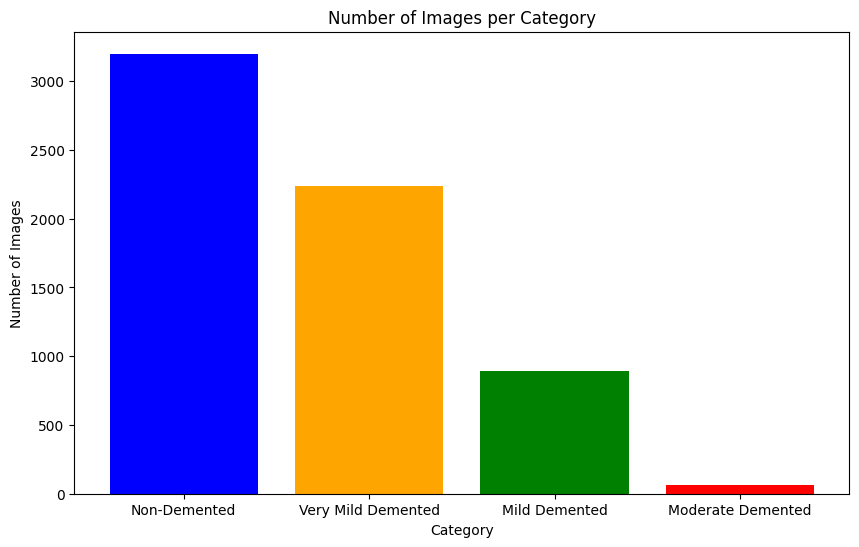

In [5]:
categories = ['Non-Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
counts = [len(non_demented), len(very_mild_demented), len(mild_demented), len(moderate_demented)]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()


C:\Users\linyo\AppData\Local\Temp\ipykernel_41596\481112307.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(categories, rotation=45)
C:\Users\linyo\AppData\Local\Temp\ipykernel_41596\481112307.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(categories, rotation=45)


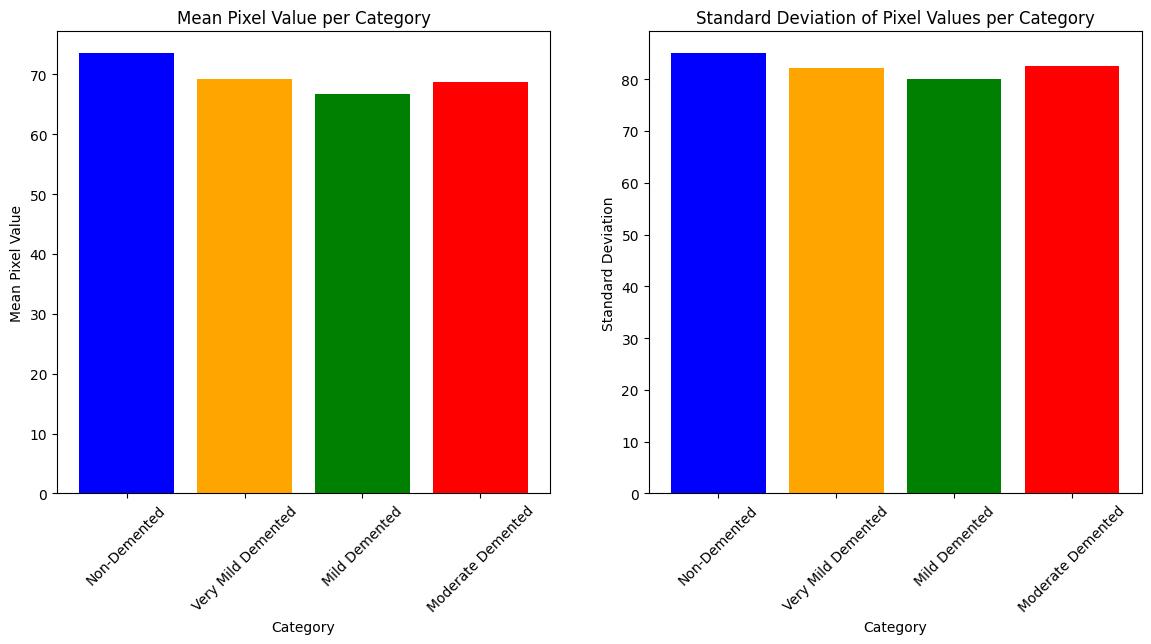

In [6]:
import numpy as np

def calculate_stats(images):
    return np.mean(images), np.std(images)

stats = {
    'Non-Demented': calculate_stats(non_demented),
    'Very Mild Demented': calculate_stats(very_mild_demented),
    'Mild Demented': calculate_stats(mild_demented),
    'Moderate Demented': calculate_stats(moderate_demented)
}

means = [stats[cat][0] for cat in categories]
stds = [stats[cat][1] for cat in categories]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(categories, means, color=['blue', 'orange', 'green', 'red'])
ax[0].set_title('Mean Pixel Value per Category')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Mean Pixel Value')
ax[0].set_xticklabels(categories, rotation=45) 


ax[1].bar(categories, stds, color=['blue', 'orange', 'green', 'red'])
ax[1].set_title('Standard Deviation of Pixel Values per Category')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Standard Deviation')
ax[1].set_xticklabels(categories, rotation=45)  
plt.show()


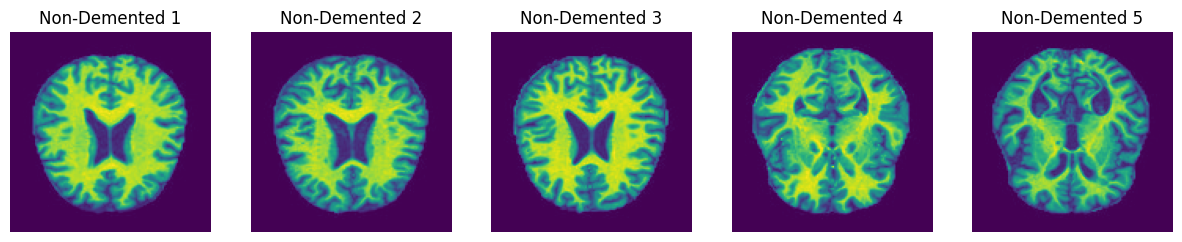

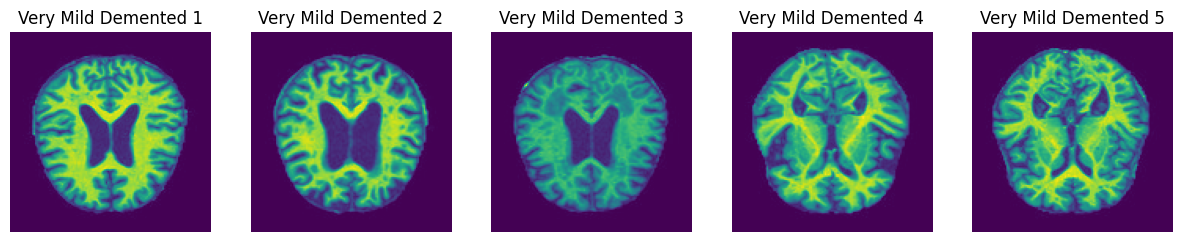

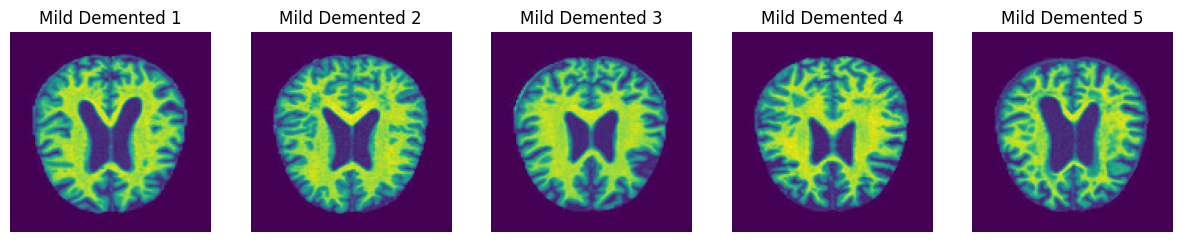

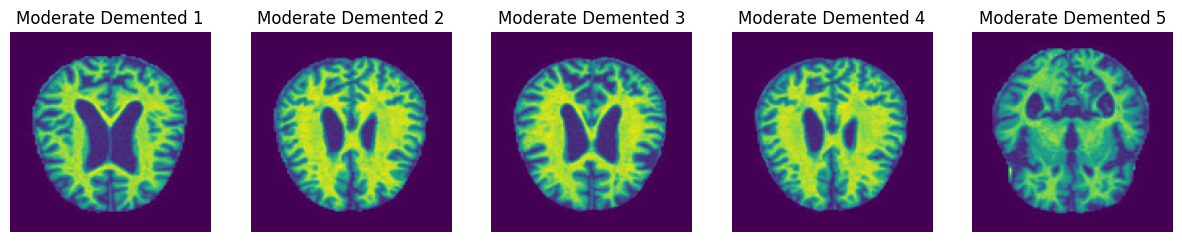

In [7]:
def plot_example_images(images, category, n=5):
    """
    Plots examples from classes

    Parameters
    ----------
    images : numpy array
        fMRI data
    category : str
        the class label
    """
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(f'{category} {i+1}')
        plt.axis('off')
    plt.show()

plot_example_images(non_demented, 'Non-Demented')
plot_example_images(very_mild_demented, 'Very Mild Demented')
plot_example_images(mild_demented, 'Mild Demented')
plot_example_images(moderate_demented, 'Moderate Demented')


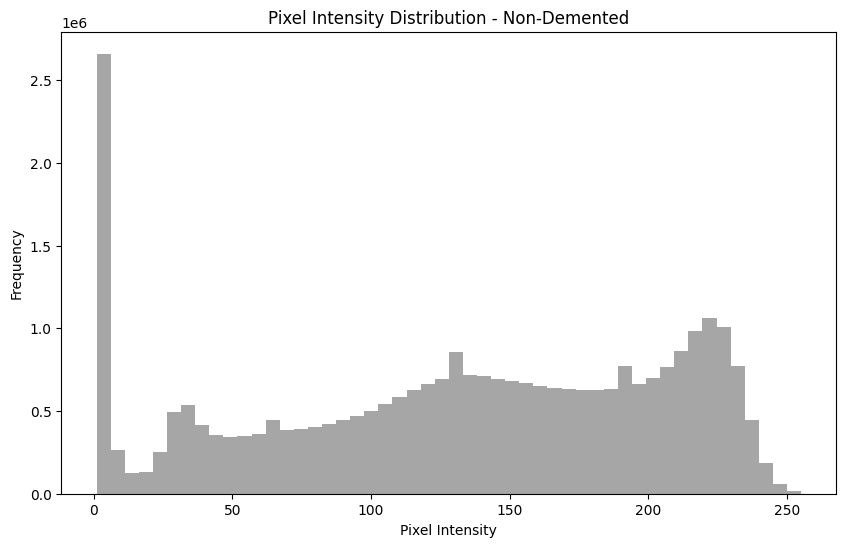

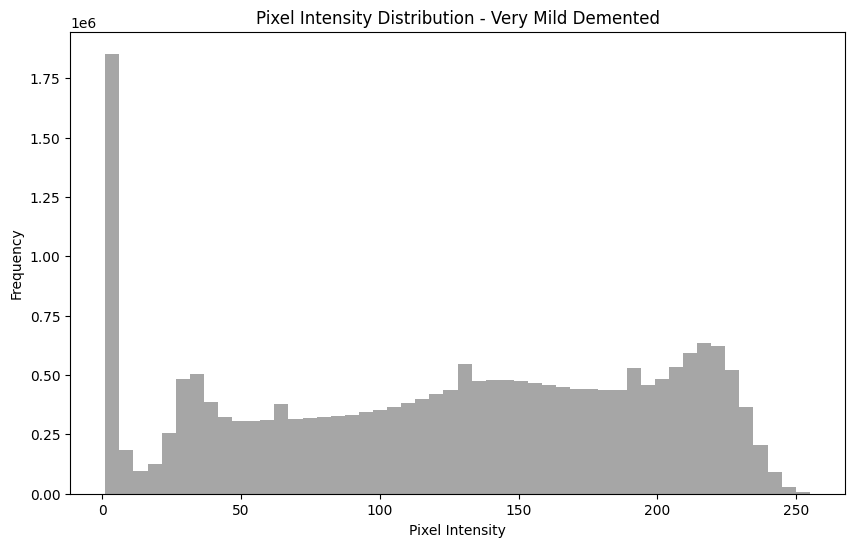

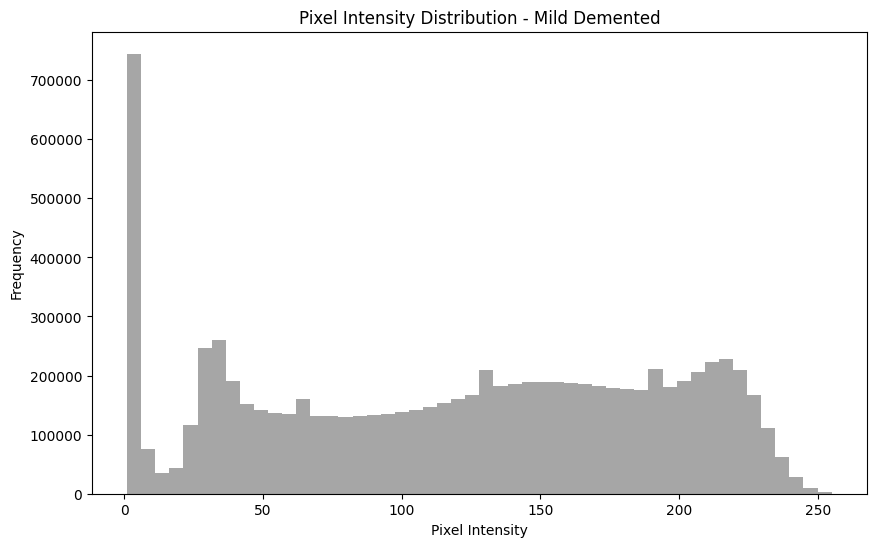

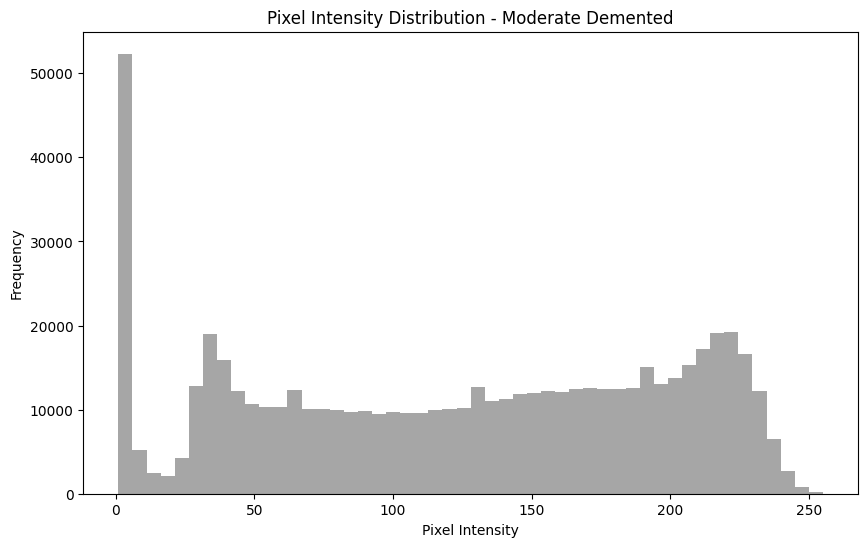

In [8]:
def plot_intensity_distribution(images, category):
    """
    Shows pixel intensity distribution

    Parameters
    ----------
    images : numpy array
        fMRI data
    category : str
        the class label
    """
    plt.figure(figsize=(10, 6))
    pixel_values = images.flatten()
    pixel_values = pixel_values[pixel_values != 0]
    plt.hist(pixel_values, bins=50, color='gray', alpha=0.7)
    plt.title(f'Pixel Intensity Distribution - {category}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_intensity_distribution(non_demented, 'Non-Demented')
plot_intensity_distribution(very_mild_demented, 'Very Mild Demented')
plot_intensity_distribution(mild_demented, 'Mild Demented')
plot_intensity_distribution(moderate_demented, 'Moderate Demented')


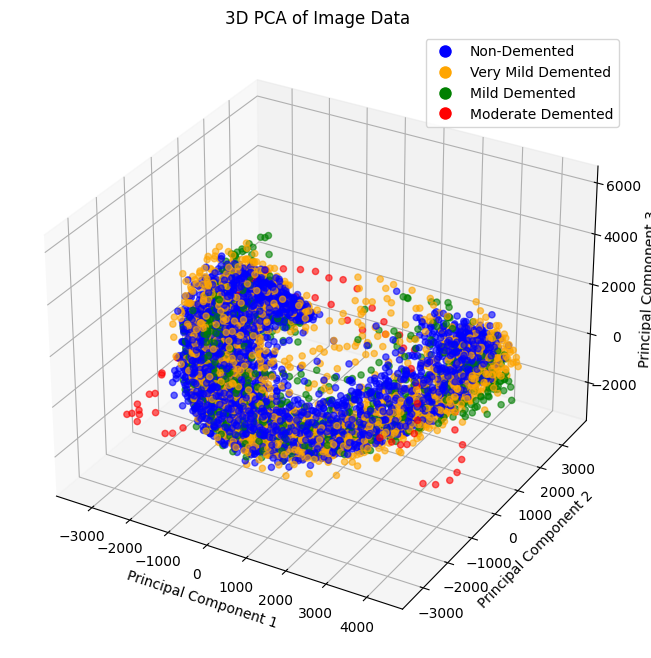

In [9]:
def apply_pca(images, n_components=3):
    """
    Function to apply PCA

    Parameters
    ----------
    images : numpy array
        fMRI data
    n_components : int
        num of components (less than k)

    Returns
    -------
    principal components
    """
    reshaped_images = images.reshape(images.shape[0], -1)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(reshaped_images)
    return principal_components

# Apply PCA to each category
non_demented_pca = apply_pca(non_demented)
very_mild_demented_pca = apply_pca(very_mild_demented)
mild_demented_pca = apply_pca(mild_demented)
moderate_demented_pca = apply_pca(moderate_demented)

# Combine all PCA results and create a corresponding label array
all_pca = np.concatenate((non_demented_pca, very_mild_demented_pca, mild_demented_pca, moderate_demented_pca), axis=0)
labels = (['Non-Demented'] * len(non_demented) +
          ['Very Mild Demented'] * len(very_mild_demented) +
          ['Mild Demented'] * len(mild_demented) +
          ['Moderate Demented'] * len(moderate_demented))

# Map labels to colors
label_color_map = {
    'Non-Demented': 'blue',
    'Very Mild Demented': 'orange',
    'Mild Demented': 'green',
    'Moderate Demented': 'red'
}

colors = [label_color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each category
ax.scatter(all_pca[:, 0], all_pca[:, 1], all_pca[:, 2], c=colors, alpha=0.6)

ax.set_title('3D PCA of Image Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in label_color_map.values()]
ax.legend(handles, label_color_map.keys())

plt.show()


### Results
 ❏    Appropriate analysis performed

 ❏    Output of analysis interpreted and interpretation included in notebook


# Conclusion & Discussion
❏    Discussion of your results and how they address your experimental question

❏    Limitations of analysis discussed

❏    What additional experiments would be interesting, and what data would you need?